# Modelling

In this notebook we will finally start working on getting a model to predict who may win in a game of chess given our variables. 

## Loading the data and libraries

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_pickle('train_df.pkl')
test = pd.read_pickle('test_df.pkl')

In [3]:
train.head()

,rated,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment,...,Counts_name_e87,Counts_name_e88,Counts_name_e90,Counts_name_e91,Counts_name_e92,Counts_name_e94,Counts_name_e95,Counts_name_e97,Counts_name_e98,winner_label
2858,0,1,0,0,0.163828,-0.976846,-0.378900,-0.648908,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0
7948,1,0,0,1,0.790929,2.243676,1.463170,1.852692,-0.397451,0.351493,...,0,0,0,0,0,0,0,0,0,2
15696,1,0,0,1,1.298583,-0.218264,-0.113780,-0.291536,-0.280300,-0.010609,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,-1.538306,-0.635484,1.783380,0.065835,0.071153,1.799901,...,0,0,0,0,0,0,0,0,0,0
14894,1,0,0,1,0.343000,-0.011379,0.020502,0.065835,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0


Recall that the winner_label is the target variable, and values of 0 indicates that the players who chose black won, 1 indicates a draw, and 2 indicates that players who chose white won.

In [4]:
y = train['winner_label']
X = train.drop(columns = 'winner_label')

In [5]:
X.head()

,rated,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment,...,Counts_name_e81,Counts_name_e87,Counts_name_e88,Counts_name_e90,Counts_name_e91,Counts_name_e92,Counts_name_e94,Counts_name_e95,Counts_name_e97,Counts_name_e98
2858,0,1,0,0,0.163828,-0.976846,-0.378900,-0.648908,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0
7948,1,0,0,1,0.790929,2.243676,1.463170,1.852692,-0.397451,0.351493,...,0,0,0,0,0,0,0,0,0,0
15696,1,0,0,1,1.298583,-0.218264,-0.113780,-0.291536,-0.280300,-0.010609,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,-1.538306,-0.635484,1.783380,0.065835,0.071153,1.799901,...,0,0,0,0,0,0,0,0,0,0
14894,1,0,0,1,0.343000,-0.011379,0.020502,0.065835,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_test = test['winner_label']
X_test = test.drop(columns = 'winner_label')

Let's do some basic modelling using default values and just checking some simple metrics like accuracy, just to see which models to the best initially.

## Logistic Regression

In [7]:
#if don't use solver='liblinear', we get an error about str not being able to decode, 
#probably related to the victory status columns
lr = LogisticRegression(solver='liblinear', random_state=42)

lr.fit(X, y)

LogisticRegression(random_state=42, solver='liblinear')

In [8]:
lr.score(X, y)

0.8231477605692759

In [17]:
y_pred = lr.predict(X_test)

In [10]:
lr.score(X_test, y_test)

0.7625026156099602

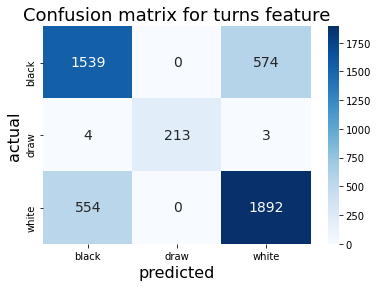

In [31]:
con_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for turns feature', fontsize=18)
plt.show()

In [46]:
parameters = {'penalty': ['l1', 'l2'], 'max_iter': [50, 75, 100, 125]}

lr = LogisticRegression(solver = 'liblinear', random_state=42)

clf = GridSearchCV(lr, parameters)

clf.fit(X, y)

GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'max_iter': [50, 75, 100, 125],
                         'penalty': ['l1', 'l2']})

In [ ]:
clf.score(X, y)

In [43]:
clf.score(X_test, y_test)

0.771918811466834

In [44]:
clf.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

## Decision Tree

We can try a decision tree first, but after if the random forest model gives a better score than we will probably just stick to that to prevent overfitting, since we have so many columns (and random forest tend to overfit less than decision trees).

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X, y)

DecisionTreeClassifier()

In [35]:
dt.score(X, y)

1.0

In [36]:
dt.score(X_test, y_test)

0.6076585059635907

Looks like the decision tree overfit based on the training data.

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X, y)

RandomForestClassifier()

In [33]:
rf.score(X, y)

1.0

In [34]:
rf.score(X_test, y_test)

0.7242100857920067

Random forest overfits on the training data again, but the testing data has a better score. The fiting time here was somewhat long though, so default values will definitely not be kept. Let's move onto Grid Search now.

In [47]:
parameters = {'n_estimators': [50, 75, 100, 125], 
              'max_depth': [3, 5, 7], 
              'min_samples_split': [3, 5, 7], 
              'min_samples_leaf':[1, 3, 5]}

rf = RandomForestClassifier(random_state=42)

clf = GridSearchCV(rf, parameters)

clf.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_split': [3, 5, 7],
                         'n_estimators': [50, 75, 100, 125]})

In [50]:
clf.score(X, y)

0.690316729454444

In [48]:
clf.score(X_test, y_test)

0.6626909395270977

In [49]:
clf.best_params_

{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 125}

## Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X, y)

GaussianNB()

In [10]:
nb.score(X, y)

0.5828798660527418

In [38]:
nb.score(X_test, y_test)

0.5024063611634233

This model seems to have done the worst. But now we can use Grid Search to assist in hyperparameter tuning.

In [55]:
parameters = {'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-8, 1e-10]}

nb = GaussianNB()

clf = GridSearchCV(nb, parameters)

clf.fit(X, y)

GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': [0.01, 0.0001, 1e-06, 1e-08, 1e-10]})

In [56]:
clf.score(X, y)

0.6414120273475652

In [57]:
clf.score(X_test, y_test)

0.6185394433982004

In [58]:
clf.best_params_

{'var_smoothing': 0.01}